# Look into detector submodules gaps - wide pixels

Let's consider only a single (top) detector module of Eiger(1) 1M at the BALDER beamline.

In [1]:
%reload_ext autoreload
%autoreload 2
#%matplotlib widget
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..

/mxn/home/zdemat/jupyter_notebooks/pd-notebooks/absorption/xtrace-sam


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt

import examplesetup
import lib.deconvolution as deconvolution
import lib.utils as utils
import lib.xtrace as xtrace

Load some data.

In [3]:
project_dir = '/data/visitors/balder/20220115/2022022408'
experiment_dir = os.path.join(project_dir, 'raw/XRD Eiger Test')
poni_dir = os.path.join(project_dir, 'process')

stacks = {
    "no_tilt_close": {
        "filename": 'LaB6_9_data_000001.h5',
        "poni": 'samuel_9_0.poni'
    },
}

data_layer = 9
saves = {}

for stack_name in stacks.keys():
    stack = stacks[stack_name]
    config, data = utils.load_stack(
        os.path.join(project_dir, experiment_dir, stack["filename"]),
        os.path.join(poni_dir, stack["poni"]),
    )
    img, mask = utils.mask(data[data_layer], False)
    saves[stack_name] = {
        "original_image": img,
    }

As indicated we let's consider only a single (top) detector module.

In [4]:
detector_scale = 100 # replace with PONI

config = {
    "detector": {
            #number of (sub)modules per direction
            "nmods":(2,4),
            #number of pixels per module per direction
            "npixmod": (256, 256), 
            #electric correlation
            "el_corr": np.array([[0.5, 0.5,   0,   0],
                                 [0.5, 0.5,   0,   0], 
                                 [  0,   0, 0.5, 0.5], 
                                 [  0,   0, 0.5, 0.5]]),
            #physical pixel dimensions
            "pixel_dims": (75.0, 75.0, 450.0), # (um)
            #energy absorbtion coefficient of detector material:
            "mu": 3.445930e-3 # (1/um) ... Sillicon
    },
    #ray origin position relative to upper left corner of detector:
    "ray_origin": np.array([detector_scale/10, detector_scale/3, detector_scale/3])        
}
config["detector"]["nvirpix"] = utils.nvirpix(config)
msz = config["detector"]["nvirpix"]

In [5]:
from matplotlib.collections import LineCollection

def plot_h_gaps(axs, show_pixel_lines=True, lw=1):
    idx_s, idx_w = utils.gaps_index(config)
    nvp = utils.nvirpix(config)
    lc = []
    # head lines
    for i, w in zip(idx_s[0], idx_w[0]):
        lc.append([(-1/2,-1/2+i),(-1/2+nvp[1],-1/2+i)])
        lc.append([(-1/2,-1/2+i+w),(-1/2+nvp[1],-1/2+i+w)])
    # pixel lines
    if show_pixel_lines:
        for i, w in zip(idx_s[0], idx_w[0]):
            for j in range(nvp[1]+1):
                lc.append([(-1/2+j,-1/2+i),(-1/2+j,-1/2+i+w)])
    lc = LineCollection(lc, color="w", lw=lw)
    return axs.add_collection(lc)

def plot_v_gaps(axs, show_pixel_lines=True, lw=1):
    idx_s, idx_w = utils.gaps_index(config)
    nvp = utils.nvirpix(config)
    lc = []
    # head lines
    for i, w in zip(idx_s[1], idx_w[1]):
        lc.append([(-1/2+i,-1/2),(-1/2+i,-1/2+nvp[0])])
        lc.append([(-1/2+i+w,-1/2),(-1/2+i+w,-1/2+nvp[0])])
    # pixel lines
    if show_pixel_lines:
        for i, w in zip(idx_s[1], idx_w[1]):
            for j in range(nvp[0]+1):
                lc.append([(-1/2+i,-1/2+j),(-1/2+i+w,-1/2+j)])
    lc = LineCollection(lc, color="w", lw=lw)
    return axs.add_collection(lc)

def draw_box(axs, xl, yl):
    lc = []
    lc.append([(xl[0],yl[0]),(xl[1],yl[0])])
    lc.append([(xl[0],yl[1]),(xl[1],yl[1])])
    lc = LineCollection(lc)
    axs.add_collection(lc)
    return lc

def plt_counts(axs, im, xlim, ylim):
    # linear index
    idx = np.arange(im.size)
    # data
    cts = im.ravel()
    # unravel index
    iy, ix = np.unravel_index(idx, im.shape)
    # filter
    lidx = np.logical_and(ix>=xlim[0],ix<=xlim[1])
    cts = cts[lidx]
    iy = iy[lidx]
    ix = ix[lidx]
    idx = idx[lidx]
    lidx = np.logical_and(iy>=ylim[0],iy<=ylim[1])
    cts = cts[lidx]
    iy = iy[lidx]
    ix = ix[lidx]
    idx = idx[lidx]
    # text labels
    h = []
    for i in range(len(idx)):
        h.append(axs.annotate(str(cts[i]), (ix[i],iy[i]), ha='center', va='center'))
    return h

def plot_counts_in_gaps(axs, im, xlim = None, ylim = None):
    idx_s, idx_w = utils.gaps_index(config)
    nvp = utils.nvirpix(config)
    idx = []
    # h-gaps
    for i, w in zip(idx_s[0], idx_w[0]):
        for j in range(w):
            idx += [*range((i+j)*nvp[1],(i+j+1)*nvp[1])]
    # v-gaps
    for i, w in zip(idx_s[1], idx_w[1]):
        for j in range(w):
            idx += [*range(i+j,nvp[0]*nvp[1]-1,nvp[1])]
    # sort
    idx = np.unique(np.sort(idx))
    # counts
    cts = im.ravel()[idx]
    # unravel index
    iy, ix = np.unravel_index(idx, nvp)
    # filter
    if xlim not in [None,[]]:
        lidx = np.logical_and(ix>=xlim[0],ix<=xlim[1])
        cts = cts[lidx]
        iy = iy[lidx]
        ix = ix[lidx]
        idx = idx[lidx]
    if ylim not in [None,[]]:
        lidx = np.logical_and(iy>=ylim[0],iy<=ylim[1])
        cts = cts[lidx]
        iy = iy[lidx]
        ix = ix[lidx]
        idx = idx[lidx]
    # text labels
    h = []
    for i in range(len(idx)):
        h.append(axs.annotate(str(cts[i]), (ix[i],iy[i]), ha='center', va='center'))
    return h

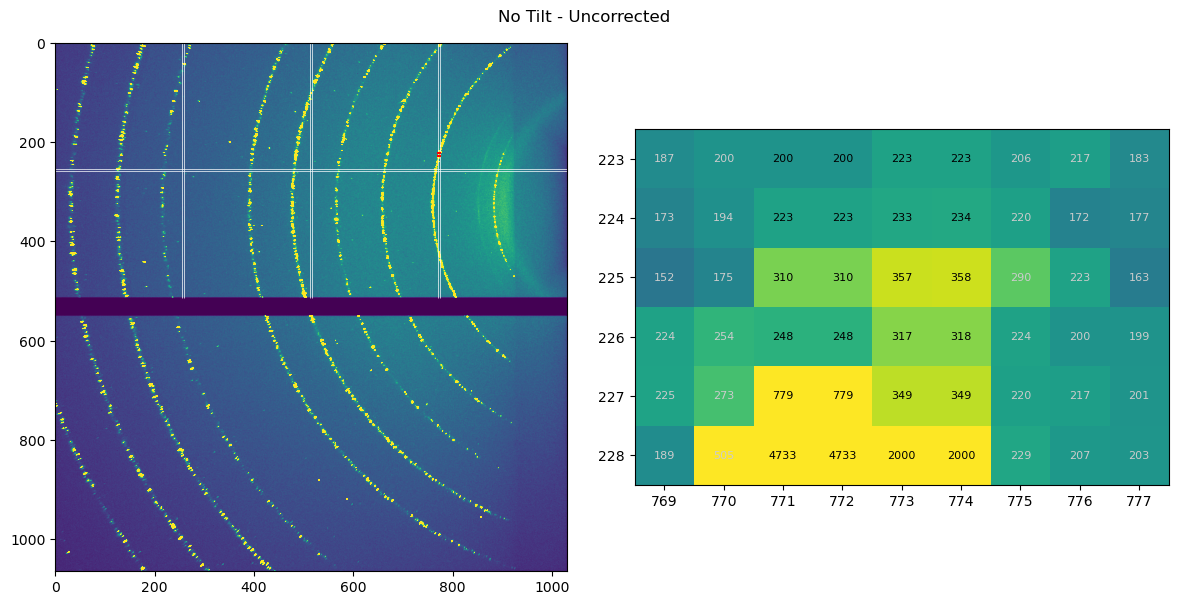

In [6]:
info = {'source': 'no_tilt_close',
        'image': 'original_image',
        'area': (slice(0,None), slice(0,None))
       }

imf = saves[info["source"]][info["image"]][info["area"]]
im = imf[:msz[0],:] # the upper module only

perc = np.percentile(im, 99)

xl=(768.5,777.5); yl=(222.5,228.5)

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=False, sharey=False)

fig.suptitle("No Tilt - Uncorrected")

# full size image
axs[0].imshow(imf, vmax=perc)
plot_h_gaps(axs[0], show_pixel_lines=False, lw=0.5)
plot_v_gaps(axs[0], show_pixel_lines=False, lw=0.5)
hl = draw_box(axs[0], xl, yl)
hl.set_color('r')

# zoom into gaps
axs[1].imshow(im, vmax=perc, origin='upper')
plt.xlim(xl)
plt.ylim(yl[::-1])
htxt1 = plt_counts(axs[1], im, xlim=(xl[0],xl[0]+2), ylim=yl)
htxt2 = plt_counts(axs[1], im, xlim=(xl[1]-3,xl[1]), ylim=yl)
plt.setp(htxt1+htxt2, fontsize=8, color='0.8')
htxt3 = plot_counts_in_gaps(axs[1], im, xlim=xl, ylim=yl)
plt.setp(htxt3, fontsize=8)

plt.tight_layout()
#plt.show()
#plt.savefig('titl_uncorrected_wide_pixels.png',dpi=300)